In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
df = pd.read_csv('train.csv')

In [262]:
df.head()


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [263]:
df.shape

(19579, 3)

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


author
EAP    7900
HPL    5635
MWS    6044
Name: id, dtype: int64


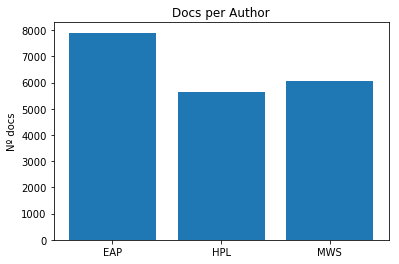

In [265]:
docs_by_author = df.groupby('author').count()['id']
print(docs_by_author)
plt.bar(np.arange(0,len(docs_by_author)),docs_by_author.values);
plt.title('Docs per Author');
plt.ylabel('Nº docs')
plt.xticks(np.arange(0,len(docs_by_author)),docs_by_author.index.values);


In [266]:
y = df.author.values
X = df.text.values

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
tfidf_train = TfidfVectorizer(stop_words='english').fit(X_train)
X_train_tfidf = tfidf_train.transform(X_train).toarray()
X_test_tfidf = tfidf_train.transform(X_test).toarray()

In [302]:
X_train_tfidf.shape

(17621, 23741)

In [303]:
X_test_tfidf.shape

(1958, 23741)

### Topic Modeling using NMF (Non-Negative Matrix Factorization)

In [273]:
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X_train_tfidf)
H = model.components_

In [274]:
top_words_per_topic = np.argsort(H, axis=1)[:,-10:]
list_of_words = tfidf_train.get_feature_names()
for i, topic in enumerate(top_words_per_topic):
    topic = topic[::-1]
    print('Topic {}'.format(i+1))
    for word in topic:
        print(list_of_words[word])

Topic 1
man
did
time
old
night
like
saw
life
day
came
Topic 2
said
dupin
let
little
sir
yes
friend
dear
know
say


### Classification using AdaBoost

In [275]:
from sklearn.metrics import log_loss
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators = 100)

In [276]:
adamodel = ada.fit(X_train_tfidf, y_train)

In [277]:
y_pred_test_proba = adamodel.predict_proba(X_test_tfidf)

In [278]:
log_loss(y_test,y_pred_test_proba)

1.0762275006441964

In [279]:
adamodel.score(X_test_tfidf, y_test)

0.58886618998978546

In [280]:
y_pred_test = adamodel.predict(X_test_tfidf)

In [281]:
y_pred_test

array(['HPL', 'EAP', 'HPL', ..., 'HPL', 'EAP', 'MWS'], dtype=object)

In [282]:
(y_pred_test==y_test).sum()/len(y_test)

0.58886618998978546

In [283]:
from sklearn.svm import SVC

svc = SVC(probability = True)
svcmodel = svc.fit(X_train_tfidf,y_train)

In [284]:
y_pred_test_svc_proba = svcmodel.predict_proba(X_test_tfidf)

In [285]:
log_loss(y_test,y_pred_test_svc_proba)

0.75665745902370962

In [286]:
y_pred_test_svc = np.argmax(y_pred_test_svc_proba, axis=1)

In [287]:
y_pred_test_svc_temp = []
for v in y_pred_test_svc:
    if v==0:
        y_pred_test_svc_temp.append('EAP')
    elif v==1:
        y_pred_test_svc_temp.append('HPL')
    else:
        y_pred_test_svc_temp.append('MWS')
y_pred_test_svc_temp = np.array(y_pred_test_svc_temp)        

In [289]:
(y_test == y_pred_test_svc_temp).sum()/len(y_test)

0.702247191011236

In [290]:
svcmodel.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [310]:
df_test = pd.read_csv('test.csv')
X = df_test.text.values
X = tfidf_train.transform(X).toarray()

In [200]:
ypred_kaggle = svcmodel.predict(X)

In [199]:
ypred_kaggle_proba = svcmodel.predict_proba(X)

In [201]:
ypred_kaggle_proba

array([[ 0.00795342,  0.00729428,  0.9847523 ],
       [ 0.69534106,  0.15907846,  0.14558048],
       [ 0.22339293,  0.70373862,  0.07286845],
       ..., 
       [ 0.62938818,  0.12090899,  0.24970282],
       [ 0.00343537,  0.00490802,  0.99165661],
       [ 0.26506919,  0.64323271,  0.0916981 ]])

In [202]:
ypred_kaggle

array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'EAP'], dtype=object)

In [189]:
svcmodel.classes_

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [207]:
with open('results.csv','w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for i, id in enumerate(df_test.id.values):
        f.write('"' + id + '",' + str(ypred_kaggle_proba[i][0]) + ',' + str(ypred_kaggle_proba[i][1]) + ',' + str(ypred_kaggle_proba[i][2]) + '\n')
    

In [206]:
ypred_kaggle_proba[0][2]

0.98475230427654192

## Testing Classifiers

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')
y = df.author.values
X = df.text.values

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
tfidf_train = TfidfVectorizer(stop_words='english').fit(X_train)
X_train_tfidf = tfidf_train.transform(X_train).toarray()
X_test_tfidf = tfidf_train.transform(X_test).toarray()

In [320]:
from sklearn.linear_model import RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV


ridge = RidgeClassifier(tol=1e-2, solver="lsqr")
clf = CalibratedClassifierCV(ridge) 
clf.fit(X_train_tfidf, y_train)
pred = clf.predict(X_test_tfidf)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
y_proba = clf.predict_proba(X_test_tfidf)
print('Log Loss:', log_loss(y_test,y_proba))



accuracy:   0.813
Log Loss: 0.488695877139


In [309]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

lsvc = LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
clf = CalibratedClassifierCV(lsvc) 
clf.fit(X_train_tfidf, y_train)
pred = clf.predict(X_test_tfidf)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
y_proba = clf.predict_proba(X_test_tfidf)
print('Log Loss:', log_loss(y_test,y_proba))

accuracy:   0.801
Log Loss: 0.50974167571


In [321]:
df_test = pd.read_csv('test.csv')
X = df_test.text.values
X = tfidf_train.transform(X).toarray()
ypred_kaggle_proba = clf.predict_proba(X)

In [322]:

with open('results-Ridge.csv','w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for i, id in enumerate(df_test.id.values):
        f.write('"' + id + '",' + str(ypred_kaggle_proba[i][0]) + ',' + str(ypred_kaggle_proba[i][1]) + ',' + str(ypred_kaggle_proba[i][2]) + '\n')
    

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier

parameters = {'alpha':[1, 5, 10]}
ridge = RidgeClassifier(tol=1e-2, solver="lsqr")
clf = GridSearchCV(ridge, parameters, scoring='log_loss', n_jobs=-1, verbose=1)
clf.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/David/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
